# Simple GP Regression

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.927   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.895   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.860   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.821   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.778   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.730   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.679   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 0.628   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.579   lengthscale: 0.371   noise: 0.369
Iter 10/50 - Loss: 0.534   lengthscale: 0.341   noise: 0.339
Iter 11/50 - Loss: 0.493   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.455   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.418   lengthscale: 0.273   noise: 0.259
Iter 14/50 - Loss: 0.383   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.347   lengthscale: 0.244   noise: 0.216
Iter 16/50 - Loss: 0.311   lengthscale: 0.234   noise: 0.196
Iter 17/50 - Loss: 0.276   length

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [8]:
print(test_x.type())

torch.FloatTensor


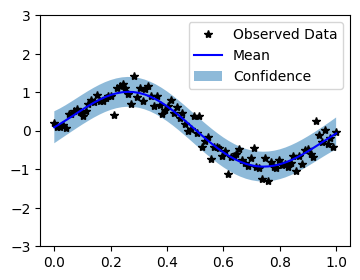

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# GP Regression with a Spectral Mixture Kernel

In [4]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
train_x = torch.linspace(0, 1, 15)
train_y = torch.sin(train_x * (2 * math.pi))

In [6]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.347
Iter 2/100 - Loss: 1.326
Iter 3/100 - Loss: 1.297
Iter 4/100 - Loss: 1.275
Iter 5/100 - Loss: 1.253
Iter 6/100 - Loss: 1.231
Iter 7/100 - Loss: 1.210
Iter 8/100 - Loss: 1.193
Iter 9/100 - Loss: 1.177
Iter 10/100 - Loss: 1.160
Iter 11/100 - Loss: 1.144
Iter 12/100 - Loss: 1.129
Iter 13/100 - Loss: 1.115
Iter 14/100 - Loss: 1.100
Iter 15/100 - Loss: 1.084
Iter 16/100 - Loss: 1.067
Iter 17/100 - Loss: 1.051
Iter 18/100 - Loss: 1.032
Iter 19/100 - Loss: 1.011
Iter 20/100 - Loss: 0.986
Iter 21/100 - Loss: 0.958
Iter 22/100 - Loss: 0.928
Iter 23/100 - Loss: 0.895
Iter 24/100 - Loss: 0.861
Iter 25/100 - Loss: 0.826
Iter 26/100 - Loss: 0.791
Iter 27/100 - Loss: 0.753
Iter 28/100 - Loss: 0.714
Iter 29/100 - Loss: 0.670
Iter 30/100 - Loss: 0.623
Iter 31/100 - Loss: 0.573
Iter 32/100 - Loss: 0.519
Iter 33/100 - Loss: 0.462
Iter 34/100 - Loss: 0.403
Iter 35/100 - Loss: 0.342
Iter 36/100 - Loss: 0.282
Iter 37/100 - Loss: 0.222
Iter 38/100 - Loss: 0.166
Iter 39/100 - Loss: 0

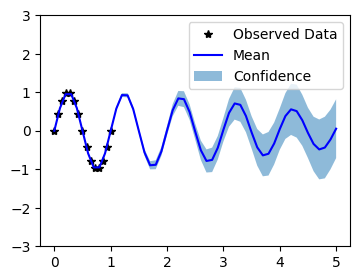

In [8]:
# Test points every 0.1 between 0 and 5
test_x = torch.linspace(0, 5, 51)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Fully Bayesian GPs-Sampling Hyperparameters with NUTS

In [2]:
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC, HMC
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 4)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Running Sampling
The next cell is the first piece of code that differs substantially from other work flows. In it, we create the model and likelihood as normal, and then register priors to each of the parameters of the model. Note that we directly can register priors to transformed parameters (e.g., "lengthscale") rather than raw ones (e.g., "raw_lengthscale").

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_samples = 2 if smoke_test else 100
warmup_steps = 2 if smoke_test else 100


from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = ExactGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y

nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=smoke_test)
mcmc_run.run(train_x, train_y)

Sample: 100%|██████████| 200/200 [00:11, 16.82it/s, step size=3.93e-01, acc. prob=0.959]


In [6]:
model.pyro_load_from_samples(mcmc_run.get_samples())

In [7]:
model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(num_samples, 1, 1)
output = model(expanded_test_x)

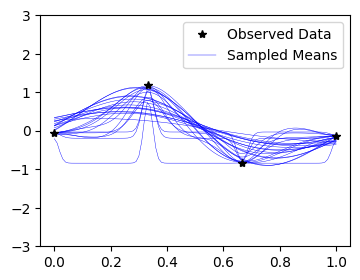

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)

    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])

# Multi-task

In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [4]:
print(train_y.shape)

torch.Size([100, 2])


In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.219
Iter 2/50 - Loss: 1.180
Iter 3/50 - Loss: 1.141
Iter 4/50 - Loss: 1.102
Iter 5/50 - Loss: 1.064
Iter 6/50 - Loss: 1.025
Iter 7/50 - Loss: 0.984
Iter 8/50 - Loss: 0.942
Iter 9/50 - Loss: 0.899
Iter 10/50 - Loss: 0.856
Iter 11/50 - Loss: 0.814
Iter 12/50 - Loss: 0.775
Iter 13/50 - Loss: 0.736
Iter 14/50 - Loss: 0.698
Iter 15/50 - Loss: 0.659
Iter 16/50 - Loss: 0.620
Iter 17/50 - Loss: 0.580
Iter 18/50 - Loss: 0.539
Iter 19/50 - Loss: 0.497
Iter 20/50 - Loss: 0.455
Iter 21/50 - Loss: 0.413
Iter 22/50 - Loss: 0.372
Iter 23/50 - Loss: 0.331
Iter 24/50 - Loss: 0.292
Iter 25/50 - Loss: 0.254
Iter 26/50 - Loss: 0.219
Iter 27/50 - Loss: 0.185
Iter 28/50 - Loss: 0.152
Iter 29/50 - Loss: 0.121
Iter 30/50 - Loss: 0.090
Iter 31/50 - Loss: 0.060
Iter 32/50 - Loss: 0.033
Iter 33/50 - Loss: 0.008
Iter 34/50 - Loss: -0.013
Iter 35/50 - Loss: -0.032
Iter 36/50 - Loss: -0.049
Iter 37/50 - Loss: -0.063
Iter 38/50 - Loss: -0.074
Iter 39/50 - Loss: -0.084
Iter 40/50 - Loss: -0.091
It